In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install sklearn-ts==0.0.3

# Load data

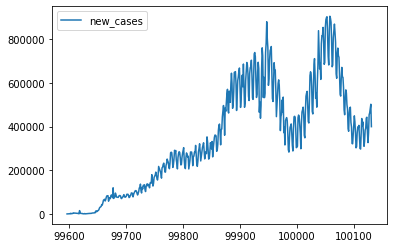

In [3]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [4]:
#data = covid[(covid['location']=='World')][['new_cases']]
#data.index = pd.PeriodIndex(pd.to_datetime(covid[(covid['location']=='World')]['date']))

# prepare features
features = [target]
categorical_features= []
dataset.index = pd.to_datetime(dataset['date'])

#Splitting data

In [5]:
from sklearn_ts.validator import check_model

# Simple

In [6]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [7]:
model = SimpleExpSmoothing(endog=dataset[target])
model_fit = model.fit(use_brute=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [8]:
y_pred = model_fit.predict(start=min(dataset.index), end=max(dataset.index))
y_pred

2020-01-22         0.000000
2020-01-23         0.000000
2020-01-24        49.000000
2020-01-25       167.500000
2020-01-26       329.750000
                  ...      
2021-07-06    367687.751293
2021-07-07    410716.375647
2021-07-08    437282.687823
2021-07-09    459408.843912
2021-07-10    481041.921956
Freq: D, Length: 536, dtype: float64

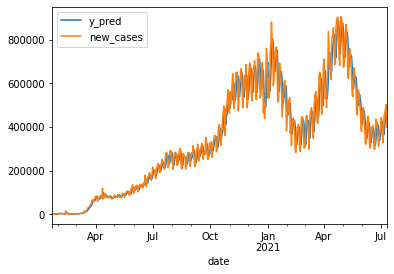

In [9]:
dataset['y_pred'] = y_pred
dataset[['y_pred', target]].plot()

# ETS

In [10]:
!pip install --upgrade statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [11]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [12]:
model = ETSModel(dataset[target], error="add", trend="add", seasonal="add", damped_trend=True, seasonal_periods=7)
fit = model.fit(maxiter=10000)
fit.get_prediction(start=min(dataset.index), end=max(dataset.index)).summary_frame(alpha=0.05)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


,mean,pi_lower,pi_upper
2020-01-22,499.999287,-60800.727846,61800.726421
2020-01-23,96.952327,-61203.774807,61397.679460
2020-01-24,876.655675,-60424.071458,62177.382809
2020-01-25,479.351545,-60821.375589,61780.078679
2020-01-26,1484.258991,-59816.468142,62784.986125
...,...,...,...
2021-07-06,406307.466480,345006.739346,467608.193613
2021-07-07,463838.137234,402537.410101,525138.864368
2021-07-08,482222.934349,420922.207215,543523.661482
2021-07-09,484371.366251,423070.639117,545672.093385


In [45]:
fit.param_names

['smoothing_level',
 'smoothing_trend',
 'smoothing_seasonal',
 'damping_trend',
 'initial_level',
 'initial_trend',
 'initial_seasonal.0',
 'initial_seasonal.1',
 'initial_seasonal.2',
 'initial_seasonal.3',
 'initial_seasonal.4',
 'initial_seasonal.5',
 'initial_seasonal.6']

In [43]:
fit.params

0        0.320324
1        0.038762
2        0.279409
3        0.945536
4      212.923810
5      303.611255
6    -1378.821429
7     2554.321428
8      438.071428
9     -368.785714
10      44.000001
11    -495.999999
12       0.000000
dtype: float64

# Custom

In [18]:
from sklearn.base import BaseEstimator, RegressorMixin


class ExpSmoothingRegressor(BaseEstimator, RegressorMixin):
    # https://www.statsmodels.org/devel/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html

    def __init__(self, error='add', trend=None, damped_trend=False, seasonal=None, seasonal_periods=None):
        self.error = error
        self.trend = trend
        self.damped_trend = damped_trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods

        self.model = None
        self.predictions= None

    def fit(self, X, y):
        model = ETSModel(y, error=self.error, trend=self.trend, seasonal=self.seasonal,
                         damped_trend=self.damped_trend, seasonal_periods=self.seasonal_periods)
        self.model = model.fit(maxiter=10000)
        return self

    def predict(self, X):
        X = np.ndarray.flatten(X)
        self.predictions = self.model.get_prediction(start=min(X), end=max(X)).summary_frame(alpha=0.1)
        return self.predictions['mean']

    def get_params(self, deep=True):
        return {"error": self.error, 'trend': self.trend, 'damped_trend': self.damped_trend, 'seasonal': self.seasonal,
                'seasonal_periods': self.seasonal_periods}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Grid search
Fitting to train
Plot


{'regressor__damped_trend': True,
 'regressor__error': 'add',
 'regressor__seasonal': 'add',
 'regressor__seasonal_periods': 7,
 'regressor__trend': 'add'}

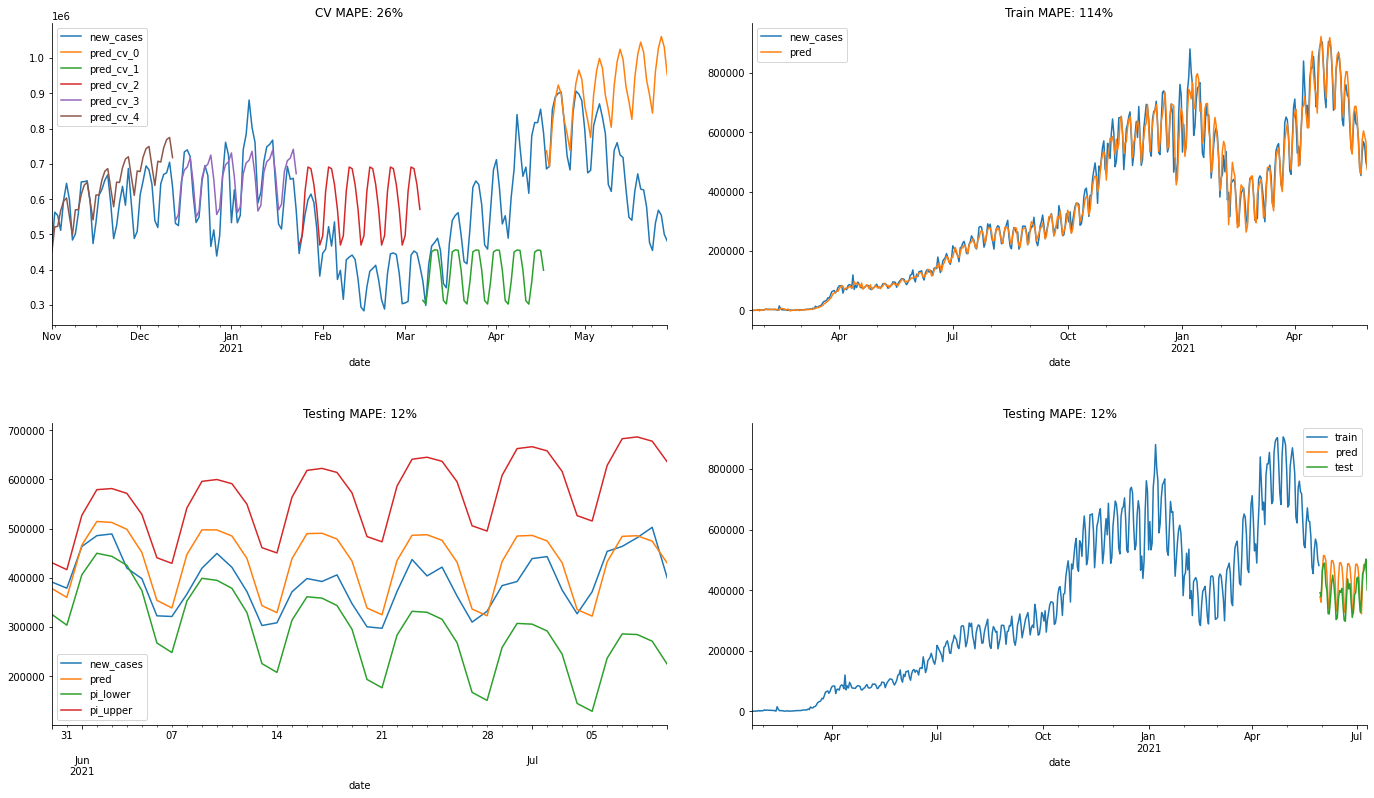

In [39]:
import warnings
warnings.filterwarnings('ignore')

features = ['date']

params = {'error': ['add'], 'trend': ['add'], 'damped_trend': [True], 'seasonal': ['add'], 'seasonal_periods': [7]}
regressor = ExpSmoothingRegressor()

results = check_model(regressor, params, dataset, h=7*6, gap=7*6)
results['best_params']

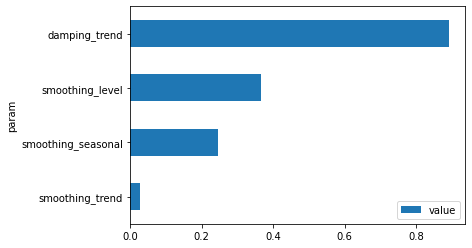

In [50]:
imp = pd.DataFrame({'param': results['model'].named_steps['regressor'].model.param_names, 'value': results['model'].named_steps['regressor'].model.params})
imp[~imp['param'].str.contains('initial')].sort_values('value', ascending=True).plot.barh(x='param', y='value')

{'regressor__damped_trend': True,
 'regressor__error': 'add',
 'regressor__seasonal': None,
 'regressor__seasonal_periods': 7,
 'regressor__trend': None}

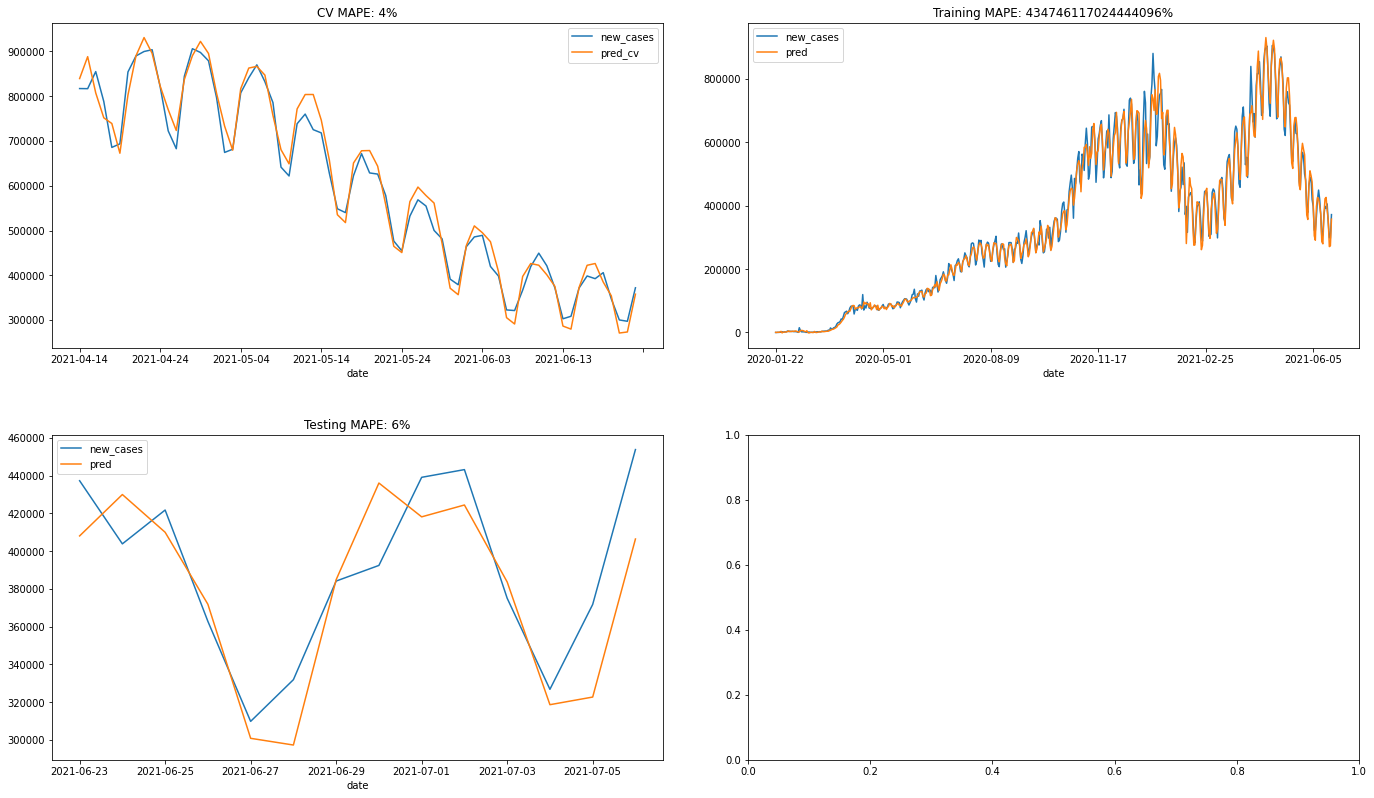

In [ ]:
features = ['date']

params = {'error': ['add', 'mul'], 'trend': [None, 'add', 'mul'], 'damped_trend': [True, False], 'seasonal': [None, 'add', 'mul'], 'seasonal_periods': [7, 30]}
regressor = ExpSmoothingRegressor()

results = check_model(regressor, params, dataset)
results['best_params']